In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from scipy.signal import hilbert, fftconvolve
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import seaborn as sns  # For better-looking heatmaps (optional)
from joblib import Parallel, delayed
import time
import networkx as nx
# C:\Users\Genchang Peng\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
Fs = 1000
## in utd computer
#sz_sample = [r"C:\Users\gxp170004\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\20_PV_1999_2099.csv", 
             #r"C:\Users\gxp170004\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\20_QM_ictal.csv",
            #r"C:\Users\gxp170004\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\2000_LA6579RH_L_ICTAL.csv",
            #r"C:\Users\gxp170004\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\2000_LA6579TI_R_ICTAL.csv",
            #r"C:\Users\gxp170004\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\20_R3_ictal.csv"]

#sz_sample = ["F:\CSV\\UTSW_2000\\2000_LA6579RH_L_ICTAL.csv", "F:\CSV\\UTSW_2000\\2000_LA6579TI_R_ICTAL.csv",
             #"F:\CSV\\UTSW_2000\\20_QM_ictal.csv", "F:\CSV\\UTSW_2000\\20_R3_ictal.csv"]
sz_sample = [r"C:\Users\Genchang Peng\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\20_PV_1999_2099.csv", 
             r"C:\Users\Genchang Peng\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\2000_LA6579RH_L_ICTAL.csv",
             r"C:\Users\Genchang Peng\OneDrive - The University of Texas at Dallas\CSV\UTSW_2000\20_QM_ictal.csv"]


notable_channels = ['LA1','LA2','LB1','LB2','LB5','LB6','LC1','LC2','LC5','LC6',
                    'RA1','RA2','RB1','RB2','RB5','RB6','RC1','RC2','RC5','RC6']

#left_indices = [i for i, name in enumerate(channel_names) if name.startswith("L")]
#right_indices = [i for i, name in enumerate(channel_names) if name.startswith("R")]
#Left_channels = ['LA1','LA2','LB1','LB2','LB5','LB6','LC1','LC2','LC5','LC6']
#Right_channels = ['RA1','RA2','RB1','RB2','RB5','RB6','RC1','RC2','RC5','RC6']
Left_channels = [name for name in notable_channels if name.startswith("L")]
Right_channels = [name for name in notable_channels if name.startswith("R")]

num_channel = int(len(notable_channels))


In [3]:

def Data_split(input_df, Timesize,overlap):  # Timesize in Sec.,
    win_size = Timesize * Fs
    #raw_SEEG = input_df.drop(channel_irrelevant, axis=1)
    raw_SEEG = input_df.loc[:,notable_channels]

    if overlap == 50:
        num_epoch = int(2*raw_SEEG.shape[0] /win_size-1)
        effect_size = int(win_size/2)
    else:
        num_epoch = raw_SEEG.shape[0] / win_size  # default non-lapping
        effect_size = win_size

    df_series = []
    count = 0
    while True:
        if count > num_epoch:
            break

        df_series.append(raw_SEEG.iloc[count*effect_size:count*effect_size+win_size])
        count += 1

    return df_series,count

raw_data_path = sz_sample[1]  ### simply for test
raw_data = pd.read_csv(raw_data_path)

#sz_series, frame_count = Data_split(input_df=raw_data, Timesize=2, overlap=50)
model_order = 10


In [4]:
freq_band_dict = {'theta': (4, 9), 'alpha': (9, 13), 'beta': (13, 30), 'gamma': (30, 55)}
def compute_dtf(data, model_order=10, f_sample=Fs, freq_band=(13, 30)):
    # Fit MVAR model using statsmodels
    var_model = VAR(data)
    results = var_model.fit(model_order)

    # Coefficients of the MVAR model
    A_list = np.array([results.coefs[i] for i in range(model_order)])  # Shape: (model_order, num_channel, num_channel)
    num_channel = data.shape[1]

    # Frequency range of interest
    f_min, f_max = freq_band
    freqs = np.linspace(f_min, f_max, 256)  # Higher resolution for integration
    omega = 2 * np.pi * freqs / f_sample  # Angular frequencies

    # Precompute terms for all frequencies and lags
    exp_omega_lag = np.exp(-1j * omega[:, None] * np.arange(1, model_order + 1))  # Shape: (num_freqs, model_order)
    exp_omega_lag = exp_omega_lag[:, :, None, None]  # Shape: (num_freqs, model_order, 1, 1)

    # Compute the system matrix H for all frequencies
    A_expanded = A_list[None, :, :, :]  # Shape: (1, model_order, num_channel, num_channel)
    H = np.eye(num_channel, dtype=np.complex128)[None, :, :] - np.sum(A_expanded * exp_omega_lag,
                                                                      axis=1)  # Shape: (num_freqs, num_channel, num_channel)

    # Compute the inverse of H for all frequencies
    H_inv = np.linalg.inv(H)  # Shape: (num_freqs, num_channel, num_channel)

    # Compute the absolute squared values of H_inv
    H_abs2 = np.abs(H_inv) ** 2  # Shape: (num_freqs, num_channel, num_channel)

    # Normalize H_abs2 row-wise for all frequencies
    H_norm = np.sum(H_abs2, axis=2, keepdims=True)  # Shape: (num_freqs, num_channel, 1)
    H_normalized = H_abs2 / H_norm  # Shape: (num_freqs, num_channel, num_channel)

    # Integrate over frequencies to compute the DTF matrix
    delta_f = (freqs[1] - freqs[0])  # Frequency bin width
    dtf_matrix = np.sum(H_normalized, axis=0) * delta_f  # Shape: (num_channel, num_channel)

    # Final row-wise normalization
    dtf_matrix /= np.sum(dtf_matrix, axis=1, keepdims=True)  # Normalize row-wise (outgoing connections)

    return dtf_matrix


In [5]:

def generate_surrogate(data, method='time_shuffling'):
    """
    Generate surrogate data using phase randomization or time shuffling.

    Args:
        data (numpy.ndarray): Input data (channels x timepoints).
        method (str): Surrogate generation method ('phase_randomization' or 'time_shuffling').

    Returns:
        numpy.ndarray: Surrogate data (channels x timepoints).
    """
    n_channels, n_samples = data.shape

    if method == 'phase_randomization':
        # FFT of the data
        fft_vals = np.fft.fft(data, axis=1)  # Shape: (n_channels, n_samples)

        # Generate random phases for positive frequencies
        random_phases = np.exp(2j * np.pi * np.random.rand(n_channels, n_samples // 2 - 1))  # Shape: (n_channels, n_samples // 2 - 1)
        fft_vals[:, 1:n_samples // 2] *= random_phases  # Apply random phases to positive frequencies
        fft_vals[:, -1:-n_samples // 2:-1] = np.conj(fft_vals[:, 1:n_samples // 2])  # Symmetry for negative frequencies

        # Inverse FFT to get surrogate data
        surrogate_data = np.real(np.fft.ifft(fft_vals, axis=1))  # Shape: (n_channels, n_samples)

    elif method == 'time_shuffling':
        # Shuffle timepoints for each channel
        surrogate_data = np.apply_along_axis(np.random.permutation, axis=1, arr=data)

    else:
        raise ValueError("Invalid surrogate method. Supported methods: 'phase_randomization', 'time_shuffling'.")

    return surrogate_data


In [6]:

def retain_top_connections(matrix, top_percent=0.25):
    """
    Retain only the top connections in the DTF matrix based on their magnitude.
    """
    threshold = np.percentile(matrix, 100 * (1 - top_percent))
    retained_matrix = np.zeros_like(matrix)
    retained_matrix[matrix >= threshold] = matrix[matrix >= threshold]
    return retained_matrix

def dtf_filtered(data, num_surro, thre=0.01, top_percent=0.25,freq_band=(13, 30)):
    """
    Apply surrogate analysis to filter DTF values based on significance.

    Args:
        data (pandas.DataFrame): Input data (channels x timepoints).
        num_surro (int): Number of surrogates to generate.
        thre (float): p-value threshold for significance.
        top_percent (float): Proportion of top values to retain.

    Returns:
        pandas.DataFrame: Filtered significant DTF values (channels x channels).
    """
    sample_data = data.to_numpy()

    # Compute original DTF
    dtf_original = compute_dtf(data=sample_data, model_order=model_order, f_sample=Fs)

    # Generate surrogate DTF values
    surrogate_dtf_values = np.zeros((num_surro, num_channel, num_channel))
    for s in range(num_surro):
        surrogate_data = generate_surrogate(data=sample_data, method="time_shuffling")
        surrogate_dtf_values[s] = compute_dtf(data=surrogate_data, model_order=model_order, f_sample=Fs, freq_band=freq_band)

    # Compute p-values for all channel pairs
    dtf_significant = np.zeros_like(dtf_original)
    for i in range(num_channel):
        for j in range(num_channel):
            if i == j:
                continue
            # Extract surrogate values for channel pair (i, j)
            surrogate_values = surrogate_dtf_values[:, i, j]
            p_value = np.mean(surrogate_values >= dtf_original[i, j])
            if p_value < thre:
                dtf_significant[i, j] = dtf_original[i, j]

    # Retain top connections
    #dtf_significant = retain_top_connections(dtf_significant, top_percent=top_percent)

    # Return as DataFrame
    significant_dtf_df = pd.DataFrame(dtf_significant, index=notable_channels, columns=notable_channels)
    return significant_dtf_df


In [7]:
def DTF_band(raw_data, band_name, freq_band_dict):
    if band_name not in freq_band_dict:
        raise ValueError(f"Band '{band_name}' not found in freq_band_dict.")
    freq_range = freq_band_dict[band_name]
    return DTF_list(raw_data, freq_band=freq_range)

def DTF_multiband(raw_data, freq_band_dict):
    """
    Run DTF estimation and surrogate filtering across multiple bands.

    Args:
        raw_data (DataFrame): Preprocessed EEG data (channels × time).
        freq_band_dict (dict): {'band_name': (low, high), ...}

    Returns:
        dict: { 'band_name': list of DTF matrices }
    """
    dtf_results = {}
    for band_name, band_range in freq_band_dict.items():
        print(f"Processing {band_name} band: {band_range}")
        dtf_results[band_name] = DTF_list(raw_data, freq_band=band_range)
    return dtf_results
#t1_time = time.time()

def DTF_list(raw_data, freq_band=(13, 30)):
    df_series, frame_count = Data_split(input_df=raw_data, Timesize=2, overlap=50)

    def process_frame(frame):
        data = df_series[frame]
        return dtf_filtered(data=data, num_surro=100, thre=0.01,top_percent=1.0, freq_band=freq_band)

    dtf_significant_list = Parallel(n_jobs=-1)(delayed(process_frame)(frame) for frame in range(frame_count))
    return dtf_significant_list



sz_series, frame_count = Data_split(input_df=raw_data, Timesize=2, overlap=50)


In [8]:
## let's get DTF series
dtf_beta_list = DTF_band(raw_data, band_name='beta', freq_band_dict=freq_band_dict)


In [18]:
def average_dtf_matrices(dtf_list):
    return np.mean(dtf_list, axis=0)

### compute features

In [19]:
## transform into graph
node_id=['LA1','LB1','LB2']#,'LC1']
def dtf_to_graph(dtf_df):
    # Convert DTF matrix to directed graph
    graph = nx.from_pandas_adjacency(dtf_df, create_using=nx.DiGraph)
    return graph

def compute_subgraph_densities(G, rns_nodes):
    """
    Computes the density of the RNS subgraph and the non-RNS subgraph.

    Args:
        G (nx.DiGraph): The full DTF-based directed graph.
        rns_nodes (list): List of node names (strings) corresponding to RNS targets.

    """
    # RNS subgraph
    rns_sub = G.subgraph(rns_nodes)
    rns_density = nx.density(rns_sub)

    # Non-RNS subgraph
    non_rns = [n for n in G.nodes if n not in rns_nodes]
    non_rns_sub = G.subgraph(non_rns)
    non_rns_density = nx.density(non_rns_sub)

    return rns_density, non_rns_density

def compute_out_strengths(G, target_nodes):
    """
    Computes the out-strength (sum of outgoing edge weights) for each node in target_nodes.

    Args:
        G (nx.DiGraph): The full DTF-based directed graph.
        target_nodes (list): List of node names (strings) to evaluate.

    Returns:
        dict: {node: out_strength}
    """
    out_strengths = {}
    for node in target_nodes:
        if node in G:
            out_edges = G.out_edges(node, data=True)
            strength = sum([attr['weight'] for _, _, attr in out_edges])
            out_strengths[node] = strength
        else:
            out_strengths[node] = np.nan  # In case node is missing

    return out_strengths


### compare density

In [21]:
rns_nodes = node_id
bands = ['alpha', 'beta', 'gamma']
density_data = []

def analyze_rns_connectivity_over_time(dtf_matrices, rns_nodes):
    rns_densities = []
    non_rns_densities = []
    for df in dtf_matrices:
        G = dtf_to_graph(df)
        rns_den, non_den = compute_subgraph_densities(G, rns_nodes)

        rns_densities.append(rns_den)
        non_rns_densities.append(non_den)

    return rns_densities, non_rns_densities
    
for band in bands:
    dtf_list = DTF_band(raw_data, band_name=band, freq_band_dict=freq_band_dict)
    avg_dtf = average_dtf_matrices(dtf_list)
    rns_dens, non_rns_dens = analyze_rns_connectivity_over_time(dtf_list, rns_nodes)
    density_data.append({'Band': band, 'Group': 'RNS', 'Density': rns_dens})
    density_data.append({'Band': band, 'Group': 'Non-RNS', 'Density': non_rns_dens})
    

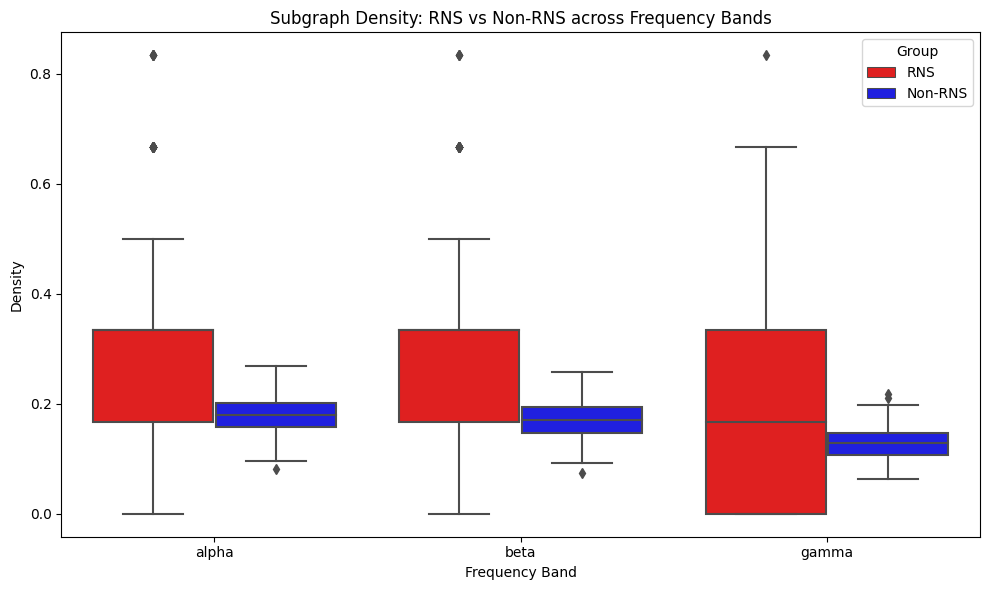

In [31]:
#print(density_data)
flat_data = []
for entry in density_data:
    band = entry['Band']
    group = entry['Group']
    for d in entry['Density']:
        flat_data.append({'Band': band, 'Group': group, 'Density': d})

df_density = pd.DataFrame(flat_data)
custom_palette = {
    'RNS': 'red',
    'Non-RNS': 'blue'
}

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Band', y='Density', hue='Group', data=df_density, palette=custom_palette)
plt.title("Subgraph Density: RNS vs Non-RNS across Frequency Bands")
plt.ylabel("Density")
#plt.ylim(0, 1)
plt.xlabel("Frequency Band")
plt.legend(title="Group")
plt.tight_layout()

plt.savefig("box_band.svg", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
import scipy.stats as stats
from scipy.stats import f_oneway

for band in bands:
    rns = df_density[(df_density['Band'] == band) & (df_density['Group'] == 'RNS')]['Density']
    non_rns = df_density[(df_density['Band'] == band) & (df_density['Group'] == 'Non-RNS')]['Density']
    #stat, p = stats.ttest_ind(rns, non_rns, equal_var=False)  # or use mannwhitneyu
    f_stat, p = f_oneway(rns, non_rns)
    print(f_stat)
    #print(f"{band} Band: p = {p:.4f}")

74.94350628746486
71.2675385664212
48.36812117444771


### compare density between rns-cluster vs other nodes

Mann–Whitney U Test: p = 0.0000


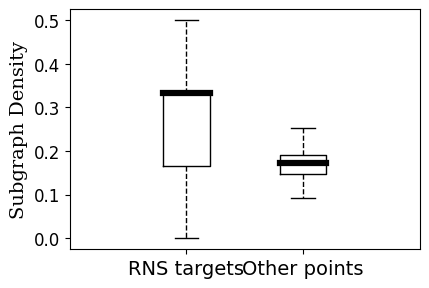

1

<Figure size 640x480 with 0 Axes>

In [13]:
from scipy.stats import mannwhitneyu
def Box_density_2(list1, list2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    from matplotlib.font_manager import FontProperties
    plt.rcParams['text.usetex'] = False  # Disable LaTeX rendering
    #plt.rcParams['font.family'] = 'Times New Roman'
    labelfont = FontProperties()
    labelfont.set_weight('normal')

    stat, p = mannwhitneyu(list1, list2, alternative='two-sided')
    print(f"Mann–Whitney U Test: p = {p:.4f}")

    data_test_1 = pd.DataFrame({'Target sets': list1, 'Other nodes': list2},
                               columns=['Target sets', 'Other nodes'])
    v1 = {}  # assign data values
    v1['Target sets'] = data_test_1.loc[:, 'Target sets']
    v1['Other nodes'] = data_test_1.loc[:, 'Other nodes']


    controls_1 = ['Target sets','Other nodes']
    colors_1 = ["red", 'green']
    # a new side-by-side boxplot
    data_to_plot = [v1['Target sets'], v1['Other nodes']]
    bplt_1 = ax.boxplot(data_to_plot, positions=[0.5, 1.0], labels=['RNS targets', 'Other points'],
                        patch_artist=False, widths=0.2, showfliers=False,
                        whiskerprops={'color': "black", 'linestyle': '--'})

    #for patch, color in zip(bplt_1['boxes'], ['black', 'blue', 'red', 'green']):
        #patch.set_facecolor(color)

    for median in bplt_1['medians']:
        median.set(color='black', linewidth=4.5)


    ax.set_ylabel('Subgraph Density', fontsize=14, fontdict={'family': 'serif'})
    #ax.set_xlabel('Connectivity', fontsize=14, fontdict={'family': 'serif'})
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=12)
    #ax.set_yticks(np.arange(0, 2.5, 0.5))

    plt.tight_layout()
    plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.1)

    plt.show()
    plt.savefig("boxcompare.svg", dpi=300, bbox_inches='tight')
    return 1


Box_density_2(list1=rns_den_list, list2=others_den_list)

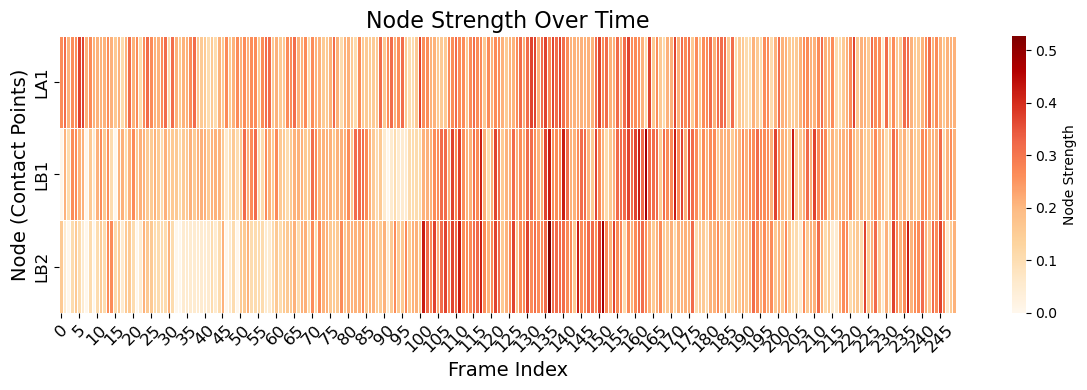

1

In [21]:

#t1_time = time.time()
def DTF_list(raw_data):
    df_series, frame_count = Data_split(input_df=raw_data, Timesize=2, overlap=50)

    def process_frame(frame):
        data = df_series[frame]
        return dtf_filtered(data=data, num_surro=100, thre=0.01,top_percent=0.25)

    dtf_significant_list = Parallel(n_jobs=-1)(delayed(process_frame)(frame) for frame in range(frame_count))
    return dtf_significant_list



sz_series, frame_count = Data_split(input_df=raw_data, Timesize=2, overlap=50)



dtf_significant_list = DTF_list(raw_data=raw_data)

def compute_nodecentrality(matrix_df,node_id):
    matrix_value = matrix_df.to_numpy()
    G = nx.from_numpy_array(matrix_value, create_using=nx.DiGraph)  ## no more from_numpy_matrix, use from_numpy_array
    mapping = {i: notable_channels[i] for i in range(num_channel)}
    G = nx.relabel_nodes(G, mapping)
    out_degree = nx.out_degree_centrality(G)
    centrality_vector = np.array([out_degree[node] for node in node_id])

    return centrality_vector



def frames_by_nodes():
    """
    Args:
    Returns:
        pandas.DataFrame: DataFrame containing frame indices, connectivity densities, and cluster labels.
    """
    # Step 1: Extract connectivity densities
    all_centrality = []
    for frame_idx, frame_matrix in enumerate(dtf_significant_list):
        centrality_vector = compute_nodecentrality(matrix_df=frame_matrix,node_id=node_id)
        all_centrality.append(centrality_vector)

    # Step 2: Create feature matrix
    centrality_array = np.array(all_centrality)

    # Step 3: Normalize the features
    df_centrality = pd.DataFrame(centrality_array,columns=node_id)

    df_centrality = df_centrality.T  # Transpose if needed

    # Create a heatmap
    plt.figure(figsize=(12, 4))  # Adjust figure size if needed
    sns.heatmap(df_centrality, cmap="OrRd", annot=False, fmt=".2f", linewidths=0.5,cbar_kws={'label':'Node Strength'})

    # Labels and title

    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)
    plt.xlabel("Frame Index", fontsize=14)
    plt.ylabel("Node (Contact Points)", fontsize=14)
    plt.title("Node Strength Over Time", fontsize=16)

    # Display the heatmap
    plt.tight_layout()
    # Show the heatmap
    plt.show()
    return 1


frames_by_nodes()
